 Assignment 5  — Breast Cancer (Binary Classification)   Objectives:  Use Permutation Importance for global feature contributions.  Apply SHAP to visualize why some patients are predicted malignant/benign.  Use LIME to generate local explanations for two patients.  Compare alignment and differences between methods. Assignment Details:  Goal: Interpret how features influence breast cancer classification across multiple explanation techniques.  Data: sklearn.datasets.load_breast_cancer()  Model: GradientBoostingClassifier  Steps: 1. Train GradientBoostingClassifier. 2. Permutation Importance: Rank features by prediction impact. 3. SHAP: Create global summary plot and local force plots for one malignant and one benign case. 4. LIME: Generate local explanations for the same two cases. 5. Compare results across methods.  Deliverables: o Permutation Importance plot. o SHAP summary + 2 force plots. o LIME explanations for 2 cases. o Comparative analysis across PI, SHAP, and LIME. Submission Requirements:  Short methods summary (3–5 lines).  Clean, runnable code/notebook.  All required plots (PI, SHAP global + local, LIME local).  5–10 bullet insights highlighting consistencies and differences. *italicized text*

In [2]:
!pip install lime
!pip install lime shap scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=61402f137f340867902a7a96449a3f527e347bac0ac4eecee003f94c62f84f76
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [6]:
!pip install shap lime matplotlib seaborn scikit-learn

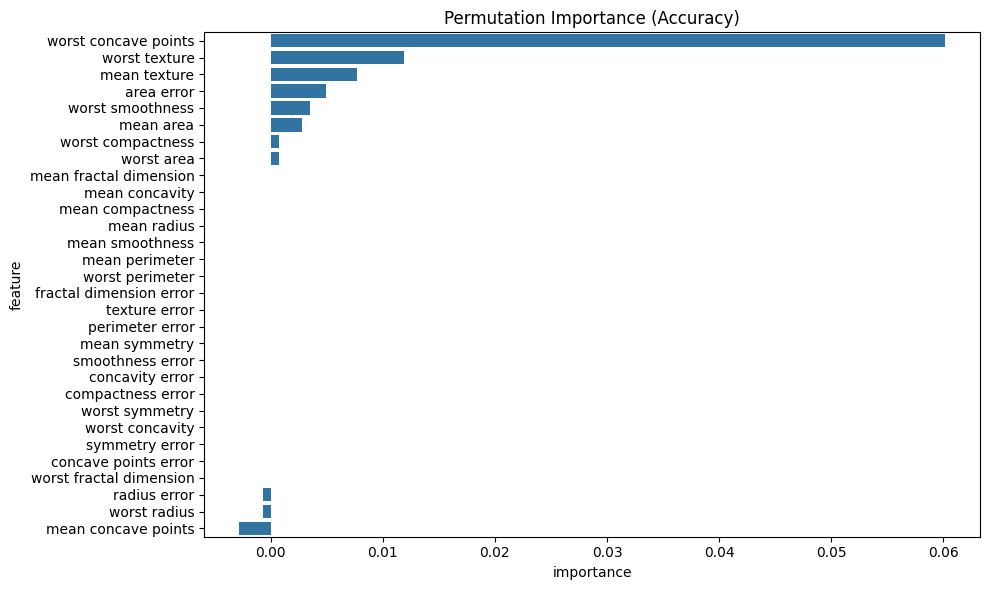

/tmp/ipython-input-2051701783.py:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


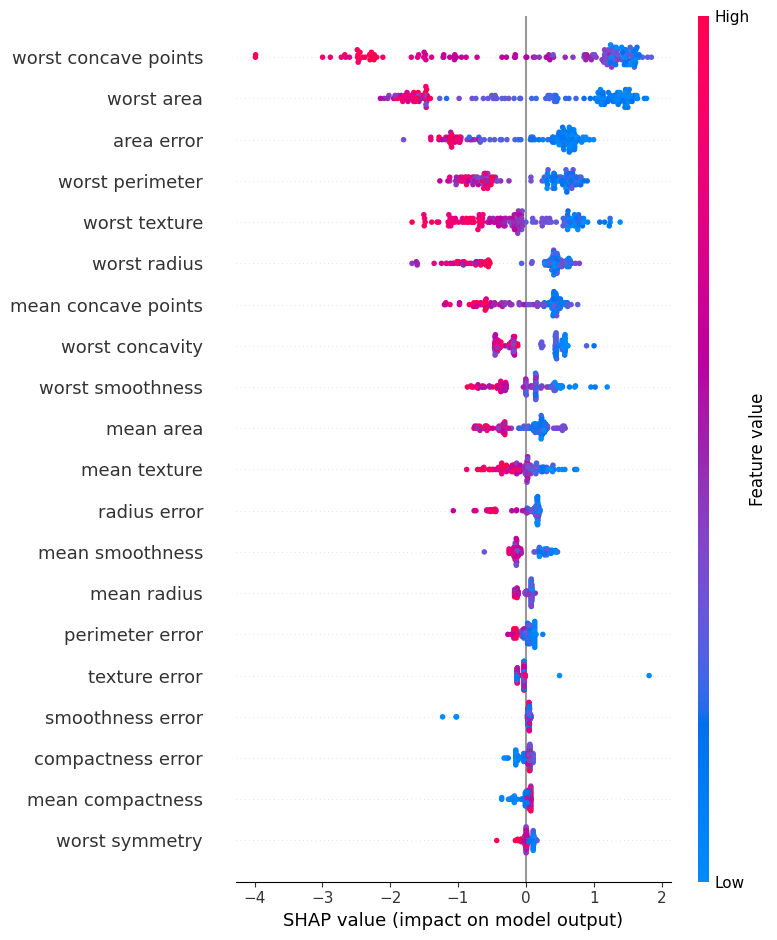

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import shap
import lime
import lime.lime_tabular

# Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Permutation Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
perm_df = pd.DataFrame({'feature': X.columns, 'importance': result.importances_mean})
perm_df.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=perm_df)
plt.title('Permutation Importance (Accuracy)')
plt.tight_layout()
plt.savefig("permutation_importance.png")
plt.show()

# SHAP Global + Local
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_plot.png")
plt.show()

# Local force plots
malignant_idx = np.where(y_test == 0)[0][0]
benign_idx = np.where(y_test == 1)[0][0]

shap.initjs()
malignant_force = shap.force_plot(explainer.expected_value, shap_values[malignant_idx].values, X_test.iloc[malignant_idx], matplotlib=False)
benign_force = shap.force_plot(explainer.expected_value, shap_values[benign_idx].values, X_test.iloc[benign_idx], matplotlib=False)

shap.save_html("shap_force_malignant.html", malignant_force)
shap.save_html("shap_force_benign.html", benign_force)

# LIME Local Explanations
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['malignant', 'benign'],
    mode='classification'
)

malignant_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[malignant_idx],
    predict_fn=model.predict_proba
)
malignant_exp.save_to_file("lime_malignant.html")

benign_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[benign_idx],
    predict_fn=model.predict_proba
)
benign_exp.save_to_file("lime_benign.html")
